In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.models import model_from_json
import pickle

In [4]:
#Open csv & add header
df = pd.read_csv('data_twitter.csv', encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])

df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
df = df.sample(50000).reset_index()


In [7]:
#Creating labels 

possible_labels = df.target.unique()
label_dict = {}
for index, label in enumerate(possible_labels):
    label_dict[label] = index
# Let's make label 0 == negative, 1 == positive

df['label'] = df.target.replace(label_dict)
df = df.drop(['date', 'flag', 'user', 'ids', 'target', 'index'], axis=1)
df.head(10)

,text,label
0,@abcdefgolden on my way,0
1,"How to Lose Stomach Fat and Get Flat Abs, Weig...",1
2,@MCFAN247 hey how are you feelin is you fam o...,1
3,@musicheroineo9 I saw him in E BUZZ and they a...,0
4,@chaserman911 Get 100 followers a day using ww...,0
5,@tommcfly You have a lovely thumb,0
6,"Just got home from work, starving and there's ...",1
7,"Women do better at University than men, accord...",0
8,@anitabora I will borrow a cycle from @infy an...,0
9,@idaydream Welcome to blip! Great song... RB ...,0


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.30, random_state=48)

In [14]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
print('prepearing train and test...')
# Train
for s in X_train:
  training_sentences.append(s)
for l in y_train:  
  training_labels.append(l)
#Test
for s in X_test:
  testing_sentences.append(s)
for l in y_test:  
  testing_labels.append(l)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

prepearing train and test...


In [15]:
vocab_size = 30000
embedding_dim = 200
max_length = 120
trunc_type = 'post'
oov_tok =  '<OOV>'

In [16]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [21]:

model = tf.keras.Sequential([
                                tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                                tf.keras.layers.Dense(128, activation='relu'),
                                tf.keras.layers.Dropout((0.2)),
                                tf.keras.layers.Dense(64, activation='relu'),
                                tf.keras.layers.Dense(1, activation= 'sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'),
                metrics=['accuracy'])

In [23]:
num_epochs = 5
history = model.fit(
    padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
    batch_size = 16 
)

Epoch 1/5
2188/2188 [==============================] - 332s 149ms/step - loss: 0.5050 - accuracy: 0.7517 - val_loss: 0.4698 - val_accuracy: 0.7759
Epoch 2/5
2188/2188 [==============================] - 296s 135ms/step - loss: 0.3233 - accuracy: 0.8587 - val_loss: 0.5081 - val_accuracy: 0.7662
Epoch 3/5
2188/2188 [==============================] - 288s 132ms/step - loss: 0.1822 - accuracy: 0.9251 - val_loss: 0.6415 - val_accuracy: 0.7609
Epoch 4/5
2188/2188 [==============================] - 287s 131ms/step - loss: 0.0998 - accuracy: 0.9606 - val_loss: 0.9189 - val_accuracy: 0.7449
Epoch 5/5
2188/2188 [==============================] - 302s 138ms/step - loss: 0.0601 - accuracy: 0.9756 - val_loss: 0.9532 - val_accuracy: 0.7485


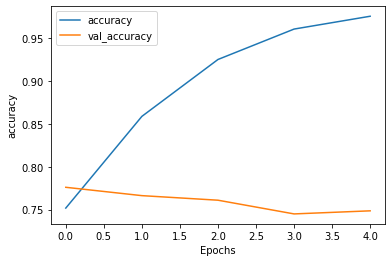

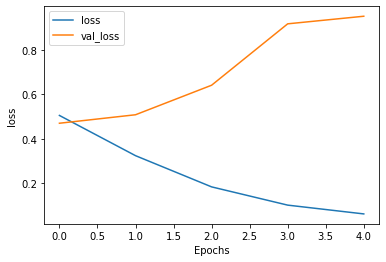

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [25]:
preds = model.predict(testing_padded)
print(classification_report(testing_labels, preds.round()))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      7578
           1       0.74      0.76      0.75      7422

    accuracy                           0.75     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.75      0.75      0.75     15000

